<a href="https://colab.research.google.com/github/susumu2357/US-patent-analysis/blob/master/colab/BERT_analysis_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir -p ./data

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
!gsutil cp gs://mlstudy-phys/data/citations_info_3000+3000.df.gz ./data/
!gsutil cp gs://mlstudy-phys/data/testset_app_3000.df.gz ./data/
!gsutil cp gs://mlstudy-phys/data/grants_for_3000+3000.df.gz ./data/

Copying gs://mlstudy-phys/data/citations_info_3000+3000.df.gz...
/ [1 files][506.5 KiB/506.5 KiB]                                                
Operation completed over 1 objects/506.5 KiB.                                    
Copying gs://mlstudy-phys/data/testset_app_3000.df.gz...
- [1 files][ 45.5 MiB/ 45.5 MiB]                                                
Operation completed over 1 objects/45.5 MiB.                                     
Copying gs://mlstudy-phys/data/grants_for_3000+3000.df.gz...
\ [1 files][129.4 MiB/129.4 MiB]                                                
Operation completed over 1 objects/129.4 MiB.                                    


In [0]:
import os
import datetime
import pickle
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
citations_info_target = pd.read_pickle("./data/citations_info_3000+3000.df.gz")
test_app = pd.read_pickle("./data/testset_app_3000.df.gz")
grants = pd.read_pickle("./data/grants_for_3000+3000.df.gz")

In [0]:
citations = citations_info_target[citations_info_target["action_type"] == 102]
cite_app = citations["app_id"]
cite_grant = citations ["parsed"]
cite_relation = pd.concat([cite_app, cite_grant], axis=1)

cite_relation.head()

,app_id,parsed
0,13836259,7746218
1,13836259,7746218
2,13836259,7746218
3,12097869,7402506
4,13718455,7908518


In [0]:
def test_label(app_id, grants, cite_relation):
  cited_parsed = cite_relation[cite_relation["app_id"] == app_id]["parsed"]
  return [ 1 if parsed == cited_parsed.values[0] else 0 for parsed in grants["parsed"] ]

In [0]:
WHOLE_APP_NUM=3000
WHOLE_GRANTS_NUM = grants.shape[0]

WHOLE_PAIR_NUM = WHOLE_APP_NUM*WHOLE_GRANTS_NUM
WHOLE_PAIR_NUM, WHOLE_GRANTS_NUM

(19320000, 6440)

In [0]:
BLOCK_SIZE = 10*WHOLE_GRANTS_NUM
TOTAL_BLOCK_NUM = WHOLE_PAIR_NUM//BLOCK_SIZE
APPS_PER_BLOCK = WHOLE_APP_NUM//TOTAL_BLOCK_NUM

BLOCK_SIZE, TOTAL_BLOCK_NUM, APPS_PER_BLOCK

(64400, 300, 10)

In [0]:
!gsutil -m cp gs://mlstudy-phys/data/results/result* ./data/

Copying gs://mlstudy-phys/data/results/result_0_64400.pkl.gz...
Copying gs://mlstudy-phys/data/results/result_0_50.pkl.gz...
Copying gs://mlstudy-phys/data/results/result_1000_1050.pkl.gz...
Copying gs://mlstudy-phys/data/results/result_10110800_10175200.pkl.gz...
Copying gs://mlstudy-phys/data/results/result_10046400_10110800.pkl.gz...
Copying gs://mlstudy-phys/data/results/result_10175200_10239600.pkl.gz...
Copying gs://mlstudy-phys/data/results/result_10304000_10368400.pkl.gz...
Copying gs://mlstudy-phys/data/results/result_10239600_10304000.pkl.gz...
Copying gs://mlstudy-phys/data/results/result_100_150.pkl.gz...
Copying gs://mlstudy-phys/data/results/result_1030400_1094800.pkl.gz...
Copying gs://mlstudy-phys/data/results/result_10368400_10432800.pkl.gz...
Copying gs://mlstudy-phys/data/results/result_10432800_10497200.pkl.gz...
Copying gs://mlstudy-phys/data/results/result_10497200_10561600.pkl.gz...
Copying gs://mlstudy-phys/data/results/result_1050_1100.pkl.gz...
Copying gs://ml

In [0]:
BLOCK_SIZE_GBM = 50
TOTAL_BLOCK_NUM_GBM = WHOLE_APP_NUM//BLOCK_SIZE_GBM

BLOCK_SIZE_GBM, TOTAL_BLOCK_NUM_GBM

(50, 60)

In [0]:
%%time

start_block_num = 0
end_block_num = TOTAL_BLOCK_NUM_GBM

ranking = []

for num in range(start_block_num, end_block_num):
  start = num * BLOCK_SIZE_GBM
  end = start + BLOCK_SIZE_GBM
  
  list = []
  
  filename = "result_{}_{}.pkl.gz".format(start, end)

  with gzip.open("./data/{}".format(filename), 'rb') as f:
    list = pickle.load(f)
    
  for app_idx in range(BLOCK_SIZE_GBM):
    app_id = test_app["app_id"][start + app_idx]
    label = pd.Series(test_label(app_id, grants, cite_relation))
    
    i, = np.where(label == 1)
    cited_index = i[0]
    rank = sorted(list[app_idx], reverse=True).index(list[app_idx][cited_index])
    ranking.append(rank)

CPU times: user 47.4 s, sys: 352 ms, total: 47.7 s
Wall time: 48 s


In [0]:
ranking_arr = np.array(ranking)

positive_counts_GBM = [sum(ranking_arr <= thrd) for thrd in range(len(grants))]

In [0]:
%%time

start_block_num = 0
end_block_num = TOTAL_BLOCK_NUM

ranking_BERT = []

for num in range(start_block_num, end_block_num):
  start = num * APPS_PER_BLOCK
  end = start + APPS_PER_BLOCK

  start_fname = num * BLOCK_SIZE
  end_fname = start_fname + BLOCK_SIZE

  list = []
  temp_list = []
  
  filename = "result_{}_{}.pkl.gz".format(start_fname, end_fname)

  with gzip.open("./data/{}".format(filename), 'rb') as f:
    temp_list = pickle.load(f)
    temp = [tup[1] for tup in temp_list]
  
  for i in range(APPS_PER_BLOCK):
    list.append(temp[i*WHOLE_GRANTS_NUM:(i+1)*WHOLE_GRANTS_NUM])
        
  for app_idx in range(APPS_PER_BLOCK):
    app_id = test_app["app_id"][start + app_idx]
    label = pd.Series(test_label(app_id, grants, cite_relation))
    
    i, = np.where(label == 1)
    cited_index = i[0]
    rank = sorted(list[app_idx], reverse=True).index(list[app_idx][cited_index])
    ranking_BERT.append((rank,list[app_idx][cited_index]))

CPU times: user 1min 22s, sys: 804 ms, total: 1min 22s
Wall time: 1min 22s


In [0]:
ranking_BERT[0:10]

[(1, 0.99998105),
 (2, 0.99998593),
 (3, 0.9999862),
 (22, 0.9999852),
 (0, 0.9999869),
 (3466, 2.3176655e-05),
 (4, 0.9999869),
 (0, 0.999987),
 (121, 0.9999796),
 (39, 0.9999856)]

In [0]:
ranking_list = [tup[0] for tup in ranking_BERT]

ranking_arr = np.array(ranking_list)

positive_counts_BERT = [sum(ranking_arr <= thrd) for thrd in range(len(grants))]

In [0]:
!gsutil cp gs://mlstudy-phys/data/results/w2v_similarities.pkl.gz ./data/

Copying gs://mlstudy-phys/data/results/w2v_similarities.pkl.gz...
/ [1 files][200.8 MiB/200.8 MiB]                                                
Operation completed over 1 objects/200.8 MiB.                                    


In [0]:
 with gzip.open("./data/w2v_similarities.pkl.gz", 'rb') as f:
    similarities = pickle.load(f)

In [0]:
%%time

ranking_w2v = []

for num in range(len(similarities)):

  app_id = test_app["app_id"][num]
  label = pd.Series(test_label(app_id, grants, cite_relation))
    
  i, = np.where(label == 1)
  cited_index = i[0]
  rank = sorted(similarities[num], reverse=True).index(similarities[num][cited_index])
  ranking_w2v.append((rank, similarities[num][cited_index]))

CPU times: user 43.3 s, sys: 18.2 ms, total: 43.3 s
Wall time: 43.3 s


In [0]:
ranking_list_w2v = [tup[0] for tup in ranking_w2v]

ranking_arr_w2v = np.array(ranking_list_w2v)

positive_counts_w2v = [sum(ranking_arr_w2v <= thrd) for thrd in range(len(grants))]

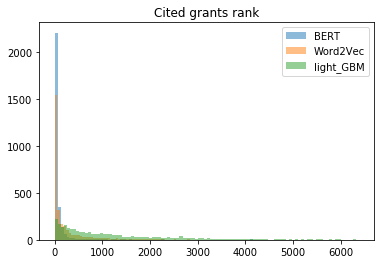

In [0]:
plt.hist(ranking_list, alpha=0.5, bins=100, label="BERT")
plt.hist(ranking_list_w2v, alpha=0.5, bins=100, label="Word2Vec")
plt.hist(ranking, alpha=0.5, bins=100, label="light_GBM")
plt.title("Cited grants rank")
plt.legend()
plt.show()

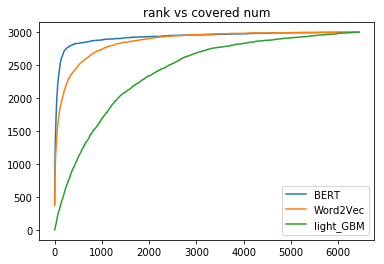

In [0]:
plt.plot(range(WHOLE_GRANTS_NUM), positive_counts_BERT, label="BERT")
plt.plot(range(WHOLE_GRANTS_NUM), positive_counts_w2v, label="Word2Vec")
plt.plot(range(WHOLE_GRANTS_NUM), positive_counts_GBM, label="light_GBM")
plt.title("rank vs covered num")
plt.legend()
plt.show()

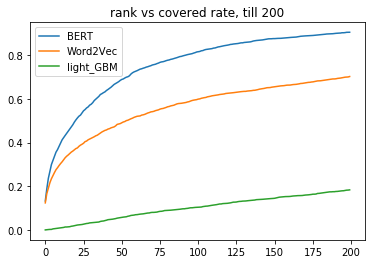

In [0]:
plt.plot(range(200), (np.array(positive_counts_BERT)/len(ranking_BERT))[0:200], label="BERT")
plt.plot(range(200), (np.array(positive_counts_w2v)/len(ranking_list_w2v))[0:200], label="Word2Vec")
plt.plot(range(200),(np.array(positive_counts_GBM)/len(ranking))[0:200], label="light_GBM")
plt.title("rank vs covered rate, till 200")
plt.legend()
plt.show()

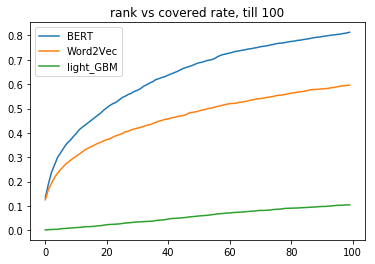

In [0]:
plt.plot(range(100), (np.array(positive_counts_BERT)/len(ranking_BERT))[0:100], label="BERT")
plt.plot(range(100), (np.array(positive_counts_w2v)/len(ranking_list_w2v))[0:100], label="Word2Vec")
plt.plot(range(100),(np.array(positive_counts_GBM)/len(ranking))[0:100], label="light_GBM")
plt.title("rank vs covered rate, till 100")
plt.legend()
plt.show()

In [0]:
print("BERT pair prediction top 10   : {:.3f}".format( (np.array(positive_counts_BERT)/len(ranking_BERT))[10]))
print("BERT pair prediction top 100  : {:.3f}".format( (np.array(positive_counts_BERT)/len(ranking_BERT))[100]))
print("BERT pair prediction top 200  : {:.3f}\n".format( (np.array(positive_counts_BERT)/len(ranking_BERT))[200]))

BERT pair prediction top 10   : 0.397
BERT pair prediction top 100  : 0.814
BERT pair prediction top 200  : 0.905



In [0]:
 (np.array(positive_counts_w2v)/len(ranking_list_w2v))[100],  (np.array(positive_counts_w2v)/len(ranking_list_w2v))[200]

(0.5983333333333334, 0.7023333333333334)